In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import matplotlib.patches as patches
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3

import os
import time
import glob

import numpy as np
from pymoc import MOC
import healpy as hp

from astropy.io.ascii import read
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
from astropy.io.misc import hdf5

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
from astropy.cosmology import z_at_value
from astropy.constants import iau2015 as const
from astropy import units as u

from herschelhelp_internal.utils import inMoc, coords_to_hpidx, flux_to_mag, mag_to_flux
from herschelhelp_internal.masterlist import find_last_ml_suffix, nb_ccplots

from pcigale.sed import SED
from pcigale.sed_modules import get_module


from utils_sf import *
import pickle
import multiprocessing as mp

import warnings
#We ignore warnings - this is a little dangerous but a huge number of warnings are generated by empty cells later
warnings.filterwarnings('ignore')


In [2]:
def get_center(bins):
    """
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
def save_seds(catalogue, filename):
    """
    """
    with open(filename, 'wb') as f:
        pickle.dump({'help_id':catalogue['help_id'], 'seds': catalogue['seds']}, f)

In [4]:
def load_sed(filename):
    """
    """
    with open(filename, "rb") as f:
        file = pickle.load(f)
        cat = Table()
        cat['help_id'] = file['help_id']
        cat['seds'] = file['seds']
    
    return cat

In [5]:
import gc
gc.collect()

44

## 1. Catalogues preparation

In [6]:
DMU_DIR = '/home/mc741/Documents/git_hub/dmu_products/'
FIELD = 'Herschel-Stripe-82'

In [7]:
mysample = Table.read('./data/clean_sfg_sample_20210524.fits', memmap=True)

In [10]:
seds_ = load_sed('./data/seds_restframe_20210607.pkl')

In [11]:
mysample[:5]

help_id,optband,nirband,ndet_total,field,ra,dec,hp_idx,ebv,redshift,zspec,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,cigale_chi2_opt,cigale_chi2_ir,cigale_chi2_red,cigale_chi2_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,f_best_u,ferr_best_u,m_best_u,merr_best_u,flag_best_u,f_best_g,ferr_best_g,m_best_g,merr_best_g,flag_best_g,f_best_r,ferr_best_r,m_best_r,merr_best_r,flag_best_r,f_best_i,ferr_best_i,m_best_i,merr_best_i,flag_best_i,f_best_z,ferr_best_z,m_best_z,merr_best_z,flag_best_z,f_best_y,ferr_best_y,m_best_y,merr_best_y,flag_best_y,f_best_j,ferr_best_j,m_best_j,merr_best_j,flag_best_j,f_best_h,ferr_best_h,m_best_h,merr_best_h,flag_best_h,f_best_k,ferr_best_k,m_best_k,merr_best_k,flag_best_k,f_best_ks,ferr_best_ks,m_best_ks,merr_best_ks,flag_best_ks,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4,sSFR
,,,,,deg,deg,,,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,uJy,uJy,,uJy,uJy,,,,,,solMass / yr
bytes27,float64,float64,float64,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,bool,bool,bool,bool,float64
HELP_J000002.187-061445.916,1.0,2.0,3.0,Herschel-Stripe-82,0.009111123039974993,-6.24608767642777,284376088,0.034871156955701955,0.163,nan,179789.75,6067.265625,False,65744.6015625,7639.1484375,False,21428.58203125,8878.232421875,False,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,2.384601062400544e+38,2.8740710374968585e+37,1.8088417795174986e+38,6.145520781081247e+37,0.1395236409551362,0.006394075082650434,4.635404970156422,0.03465263511404564,0.05000000074505806,decam_stellarity,False,False,0,3,3,-99,False,nan,nan,nan,nan,False,159.1271308126664,0.5405060159880236,18.395639419555664,0.0036879125982522964,False,387.30652135321577,0.9056666586605819,17.42986297607422,0.002538854954764247,False,588.0144111586955,1.3059458964238544,16.976530075073242,0.0024113571271300316,False,818.1799184951855,2.398398076274358,16.617877960205078,0.0031827078200876713,False,978.6741617913505,5.982922944427278,16.423404693603516,0.006637424696236849,False,1479.2166748046875,29.609825134277344,15.974920272827148,0.021733436733484268,False,2076.770751953125,46.82686233520508,15.606528282165527,0.024481095373630524,False,nan,nan,nan,nan,False,2293.075439453125,47.70576477050781,15.498953819274902,0.02258795127272606,False,nan,nan,nan,nan,nan,nan,nan

In [12]:
seds_[:5]

help_id,seds
bytes27,object
HELP_J000002.187-061445.916,<pcigale.sed.SED object at 0x7f12c536ac40>
HELP_J000004.805-063531.209,<pcigale.sed.SED object at 0x7f12b0ca4850>
HELP_J002728.237-030737.134,<pcigale.sed.SED object at 0x7f12b0ca45e0>
HELP_J002728.472-011933.054,<pcigale.sed.SED object at 0x7f12b0ca49a0>
HELP_J002728.573-005425.046,<pcigale.sed.SED object at 0x7f12b0ca4a60>


In [13]:
Vmax = join(mysample[['help_id', 'ra', 'dec', 'redshift', 'zspec', 'cigale_mstar', 'cigale_mstar_err', 'cigale_sfr', 'cigale_sfr_err']], seds_, keys='help_id')

In [14]:
Vmax[:5]

help_id,ra,dec,redshift,zspec,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,seds
,deg,deg,,,solMass,solMass,solMass / yr,solMass / yr,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,object
HELP_J000002.187-061445.916,0.009111123039974993,-6.24608767642777,0.163,nan,179877911299.4444,29394960727.309006,51.601867735606945,11.828451511676093,<pcigale.sed.SED object at 0x7f12c536ac40>
HELP_J000003.896-060443.865,0.016233477238149878,-6.078851323839063,0.5962,nan,99515305206.61322,23733859449.25537,50.142788869214996,18.889928883736317,<pcigale.sed.SED object at 0x7f1293327e20>
HELP_J000004.805-063531.209,0.0200206346240566,-6.592002602896851,0.2717,nan,4943819110.759395,1100014339.6862645,11.764715888836056,3.1934716690051816,<pcigale.sed.SED object at 0x7f12b0ca4850>
HELP_J000005.706-055738.429,0.023775708492150632,-5.960674794915343,0.5885,0.5774367,143030536787.49954,28314010512.76425,58.22327291370247,17.462668556709374,<pcigale.sed.SED object at 0x7f1293335040>
HELP_J000008.766-040925.186,0.03652383700842073,-4.1569962040612864,0.3134,nan,30517090598.38414,6624200726.605916,22.186070338070458,11.354892328781553,<pcigale.sed.SED object at 0x7f12a281ad60>


### 1.2 Prepare final catalogue to work with

Our final sample are sources that has passed our selection function and the final HELP pipeline

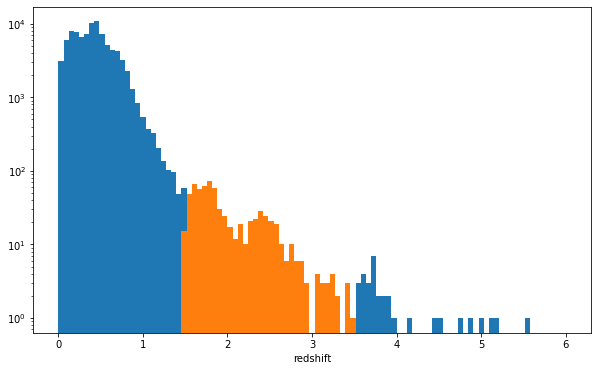

In [13]:
plt.hist(Vmax['redshift'], bins=np.linspace(0,6,100));
plt.hist(Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 3.5)]['redshift'], bins=np.linspace(0,6,100));
plt.yscale('log')
plt.xlabel('redshift')

plt.show()


In [31]:
# Define sample to use
#######################
Mass = 'cigale_mstar'
redshift = 'redshift'
SFR = 'cigale_sfr'

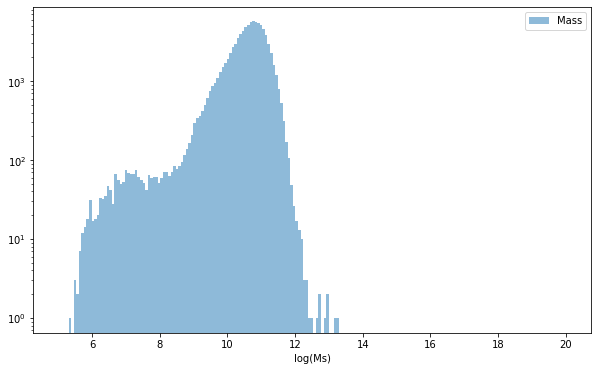

In [16]:
plt.hist(np.log10(Vmax[Mass]), bins=np.linspace(5,20,200), alpha=0.5, log=True, label='Mass');
plt.legend();
plt.xlabel('log(Ms)');

In [17]:
zmin = 1
zmax = 3
zind = (Vmax['redshift']>=zmin) & (Vmax['redshift'] <= zmax)

print('Total sample: ', len(mysample[zind]))
print('logM >= 11Ms: ',len(mysample[(zind) & (np.log10(mysample['cigale_mstar'])>=11)]))

Total sample:  2238
logM >= 11Ms:  608


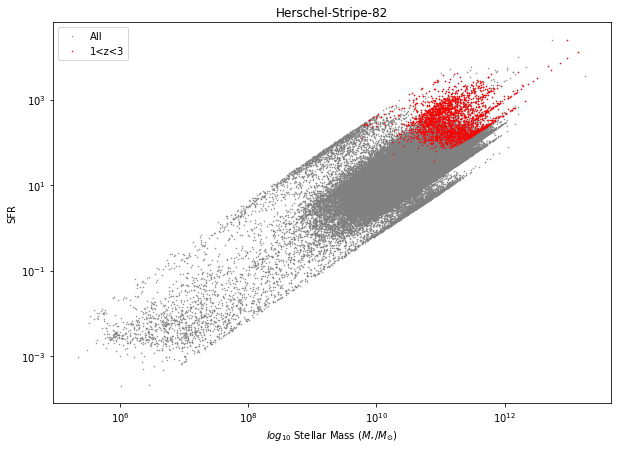

In [18]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[Mass], Vmax[SFR], '.', markersize= 1, color='grey', label='All');
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('SFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

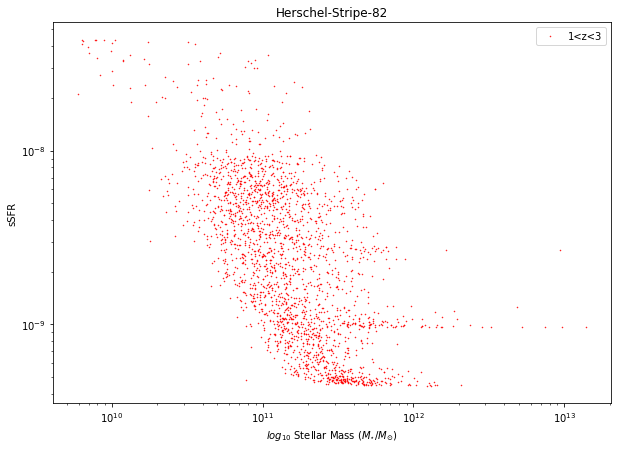

In [19]:
plt.figure(figsize=(10,7))
plt.plot(Vmax[zind][Mass], Vmax[zind][SFR]/Vmax[zind][Mass], '.', markersize= 1, color='red', label='1<z<3');

plt.xlabel(r'$log_{10}$ Stellar Mass $(M_{\star} / M_{\odot})$')
plt.ylabel('sSFR')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.title(FIELD)
# plt.savefig('./data/figs/Mscale_Alist_' + FIELD + '.png', format='png')

plt.show()

## 2. Vmax

Functions to use

In [15]:
def get_areas(mocs, row):
    """
    This function gets the area in which an object is observed, 
    based on whether it has been detected or not at a particular band/survey.
    
    param.
    ---------------
    mocs: dict of MOC()
        dictionary including MOCs for each survey/band.
    row: astropy.Table.row
        It should include Boolean columns for each moc_band.
    
    output
    ---------------
    area: float 
        Area in which the source have been detected.
    """
    
    row['areas'] = MOC()
    for key in mocs.keys():
#         print('getting area from ', key)
        if row['moc_'+key] == True:
#             print('It is in')
            row['areas'] += mocs[key]
        else:
#             print('it\'s not in')
            continue
    
    area = row['areas'].area
    
    return area


def select_sample_at_z(catalogue, allbands, mocs, flims, ndet=2):
    """
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    ndet: int
        Number of detections required per group of bands (opt/nir/mid). 
        Default 2; it requires 2 detection on each to pass the selection.
    
    output
    ---------------
    nb_band: astropy.Table 
        Table with selected sources -has at least "ndet" detections above the magnitude cut.
        And the area in which each source has been observed.
    """
    
    import numpy as np
    from astropy.table import Column, Table, join
    import time
    from pymoc import MOC
    
    nb_band = {}
    nb_band['help_id'] = catalogue['help_id']
    nb = ['optband', 'nirband', 'mirband']
    nx = ['optvalue', 'nirvalue', 'mirvalue']
    
    catalogue.add_column(Column(data=np.full(len(catalogue), np.empty(1)), dtype='object', 
                       name='areas'))

    r_filter = np.zeros(len(catalogue))
    names_= []
    for idx, bands in enumerate(allbands):
        nb_band[nb[idx]] = np.zeros(len(catalogue))
        nb_filter = np.zeros(len(catalogue))

        for i, filt in enumerate(bands):
            mocs_filt = [[k,f] for k,f in flims.items() if filt in k]
            ind = np.zeros(len(catalogue))
#             print('filter: ', filt)
            for key, val in mocs_filt :
#                 print('k: ', key)
#                 print('val: ', val)
                names_.append('moc_'+key)
                catalogue['moc_'+key] = catalogue['f_'+filt] >= val 
                ind_filter = 1 * (catalogue['f_'+filt] >= val)
                ind += ind_filter
            # As we can have two detections in the same filter in different surveys, e.g.: DECaLS_g and DECam_g    
            ind = 1 * (ind > 0)
            nb_filter += ind  
            
            if '_r' in filt:
                r_filter += ind 

        # sources detected in at least two filters of those bands (opt, nir, mir)
        if idx==2:
            n = 2
        else:
            n = 1
        # add flag: 1 * opt ; 2 * nir ; 4 * mir    
        nb_band[nb[idx]] += (idx+n) * (nb_filter >= ndet) 
    
    nb_band = Table(nb_band)
    # at least 1det in r band
    has_r_det = 1 * (r_filter >= 1)
    nb_band['optband'] = nb_band['optband'] * has_r_det
        
    total = np.zeros(len(catalogue))
    for i in range(len(allbands)):
        total += nb_band[nb[i]]

    nb_band['ndet_total'] = total
    for name in names_:
        nb_band[name] = catalogue[name]
        
    # add areas
    selected = nb_band['ndet_total'] == 3
    nb_band['areas'] = np.zeros(len(catalogue))
    t = time.time()
    nb_band['areas'][selected]  = catalogue[selected].to_pandas().apply(lambda x: get_areas(mocs,x), axis=1)   
    print('time getting areas: ', time.time() - t)
    
    return nb_band

In [16]:
def get_fluxes_at_z(sed_cat, sed_bands, r):
    """
    This function gets the fluxes of each source at the given bands, at a particular redshift "r"
    by redshifting the sed using CIGALE.
    
    param.
    ---------------
    sed_cat: pcigale.sed
        sed of the source at the restframe.
    sed_bands: list
        name of filters to compute the flux in cigale.
    
    output
    ---------------
    cat: astropy.Table 
        Catalogue containing the fluxes of each source at the given redshift.
    """
    cat = sed_cat.copy()
    new_sed = 'sed_z'+str(r)
    cat.add_column(Column(data=np.full(len(sed_cat), np.nan), dtype='object', 
                           name=new_sed))
                          
    mod = get_module("redshifting", redshift=r)
    for i in range(len(cat)):
        sed = (cat['seds'][i]).copy()
        mod.process(sed)
        cat[new_sed][i] = sed
    
    for band in sed_bands:
        cat['f_'+band] = cat.to_pandas().apply(lambda x: x[new_sed].compute_fnu(band), axis=1)
        
    return cat

In [17]:
def Vmax_i(area, z_min, z_max, cosmo):
    """
    """
    volume = (cosmo.comoving_volume(z_max) - cosmo.comoving_volume(z_min)) * (area/ (4* np.pi))
    return volume

In [18]:
def Vmax(catalogue, allbands, mocs, flims, cosmo, zmin, zmax, nbins=50):
    """
    It calculates the maximum volume each source can be observed, in a given redshift bin. 
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue 
    allbands: list [[..., str]]
        Names of bands used in the selections: [[opt_bands], [nir_bands], [mir_bands]]
    mocs: dict of MOC()
        Dictionary including MOCs for each survey/band.
    flims: dict
        Flux cuts limits for each band.
    cosmo: astropy.cosmology
        Cosmology parameters.
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    nbins: int
        Number of dz inside the bin. 
        
    output
    ---------------
    Vmax: astropy.Table 
        Table including the Vmax calculation for each source.
    """
    # Bin volume
    Vmax = catalogue.copy()
    Vmax['areas'] = np.nan
    Vmax['Vmax'] = 0.
    
    # Get sed at restframe
    seds_cat = catalogue[['help_id','seds']]
    sed_bands = [b for band in allbands for b in band]
    
    # Iterate over redshifts to get Vmax
    redshifts = np.linspace(zmin, zmax, nbins)    
    for i, r in enumerate(redshifts):
        start_r = time.time()
        print('z: ', r)
        if i==0:
            zmin_ = zmin
        else:
            zmin_ = redshifts[i-1]
        
        # Redshift the sed and get the fluxes at redshift r
        start_z = time.time()
        z_fluxes = get_fluxes_at_z(seds_cat, sed_bands,r)
        end_z = time.time()
        print('time z flux: ', end_z - start_z)
        
        start_sf = time.time()
        ind_sf = select_sample_at_z(z_fluxes,allbands,flims, mocs)
        end_sf = time.time()
        print('time sf: ', end_sf - start_sf)
        
        # Select just galaxies with 2opt and 2NIR detection --> ndet_total == 3
        start_Vmax = time.time()
        ind = ind_sf['ndet_total'] == 3
        print('There are: ', ind.sum(), ' galaxies detected at z: ', r)
        
        # Calculate Vmax for the selected sources
        # dV =  dV/(dzdΩ) * dz * dΩ
        dV = cosmo.differential_comoving_volume(r) * (r - zmin_) * ((ind_sf['areas'][ind]))# / (4* np.pi))
        
        Vmax['Vmax'][ind] = Vmax['Vmax'][ind] + dV.value
        end_Vmax = time.time()
        print('time Vmax: ', end_Vmax - start_Vmax)
        
    Vmax['Vmax'].unit = dV.unit * u.steradian
    
    return Vmax

In [19]:
def plot_SMF(zmin, zmax, catalogue, mcol, zcol, 
             nbins=None, bin_width=None, bin_percent=None):
    """
    Plot the Galaxy Stellar Mass Function between "zmin"-"zmax".  
    
    param.
    ---------------
    catalogue: astropy.table
        HELP catalogue. 
    zmin: float
        Minimum redshift bin.
    zmax: float
        Maximum redshift bin.
    mcol: str
        Name of column for Mass
    zcol: str
        Name of column for redshift.
    nbins: int
        Number of Mass bins
    bin_width: float
        Mass bin width
    bin_percent: int
        Percentage of sources on each Mass bin.
        
    output
    ---------------
    gsmf_bins: astropy.Table 
        Table including the Mass_centers and dN_dM for each Mass bin.
    """

    ind = ~np.isnan(catalogue[mcol])
    mask = (catalogue[ind][zcol] >= zmin) & (catalogue[ind][zcol] <= zmax)

    redshifts = catalogue[mask][zcol]
    Mstar = catalogue[mask][mcol]
    
    Mmin = np.log10(Mstar.min())
    Mmax = np.log10(Mstar.max())
    print('Mmin: ', Mmin)
    print('Mmax: ', Mmax)
    if nbins is not None:
        limits = np.linspace(Mmin, Mmax, nbins)
        binning = 'nbins:'+str(nbins)
    
    if bin_width is not None:
        limits = np.arange(Mmin, Mmax, bin_width)
        binning = 'binwidth:'+str(bin_width)
        
    if bin_percent is not None:
        limits = [Mmin]
        binning = 'binpercent:'+str(bin_percent)
        for i in np.arange(bin_percent,100,bin_percent):
            limits.append(np.percentile(np.log10(Mstar), i))

        limits.append(Mmax)
    
    
    bins_cent = get_center(np.array(limits))
    nbins = len(bins_cent)
    
    print('Mbin centers: ', bins_cent)
    print('Mbin limits: ', limits)
           
    gsmf_bins = Table()
    gsmf_bins.add_column(Column(data=bins_cent, name='M_centers'))
    gsmf_bins.add_column(Column(np.full(len(gsmf_bins), np.nan), name='dN_dM'))
    
    for i in range(nbins):
        # Number sources per bin
        ind = (np.log10(Mstar) > limits[i]) & (np.log10(Mstar) <= limits[i+1])
        dN = ind.sum()
        print('#sources bin', str(i), ': ', ind.sum())
        if dN == 0:
            continue
            
        Vmax = catalogue[mask]['Vmax']
        Vmax[Vmax==0] = np.nan
        dN = np.nansum( 1 / Vmax)

        binwidth = limits[i+1] - limits[i]
        dN_dM = dN / binwidth
        gsmf_bins['dN_dM'][i] = dN_dM 
    
    # Plot GSMF    
    plt.grid(True)
    plt.vlines(11.5,-8.5, 0., colors='grey', linestyles='dashed')
    plt.plot(gsmf_bins['M_centers'] , np.log10(gsmf_bins['dN_dM']), 'o', markersize= 3, label='help')
    plt.plot(sherman19['Mcenter'], sherman19['dN_dM'], 'x', color='red', label='sherman+19')

    plt.title('{} < z < {} $\quad$ [{}]'.format(zmin, zmax, binning))
    plt.xlabel(r'$log$ Stellar Mass $(M_{\star} / M_{\odot})$')
    plt.ylabel('log φ($Mpc^{-3}$ $dex^{-1}$)')
    plt.ylim([-9.,-2.])
    plt.xlim([10.,13.])
    plt.legend()

#     plt.savefig('./data/gsmf_{}_z{}_z{}.png'.format(FIELD, str(zmin), str(zmax)))

    return gsmf_bins

In [21]:
helpbands = [['sdss_u',
  'suprime_g',
  'decam_g',
  'sdss_g',
  'suprime_r',
  'decam_r',
  'sdss_r',
  'suprime_i',
  'decam_i',
  'sdss_i',
  'suprime_z',
  'decam_z',
  'sdss_z',
  'suprime_y',
  'decam_y'],
 ['vista_y',
  'ukidss_y',
  'vista_h',
  'ukidss_h',
  'vista_j',
  'ukidss_j',
  'vista_ks',
  'ukidss_k']]


In [22]:
magcuts_sdss = {'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5}

magcuts_hsc = {
    'suprime_g': 25.4,
    'suprime_r': 25.4, 
    'suprime_i': 25.1,
    'suprime_z': 24.2,
    'suprime_y': 23.7}

magcuts_des = {'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6}

magcuts_decals =  {'decam_g_decals': 23.9, 'decam_r_decals': 23.5, 'decam_z_decals': 22.5}

# vhs - s/n > 3
magcuts_vhs = {'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6}

# vics - s/n > 5
magcuts_vics = {'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0}

magcuts_ukidss = {'ukidss_h':19.0, 'ukidss_j':19.0, 'ukidss_k':19.0, 'ukidss_y':20.2}

mcuts = magcuts_sdss.copy()

mcuts.update(magcuts_hsc)
mcuts.update(magcuts_des)
mcuts.update(magcuts_decals)
mcuts.update(magcuts_vhs)
mcuts.update(magcuts_vics)
mcuts.update(magcuts_ukidss)


# Calculate flux limits based on the magnitude limits
flims = {}
for key, value in mcuts.items():
    flims[key] = mag_to_flux(value)[0] * 1e3 # mJy

In [23]:
#Read mocs
moc_list = glob.glob('./data/mocs/*.fits')
len(moc_list)


mocs_files = {}
for key in flims.keys():
#     print(key)
    mocs_files[key] = MOC()
    file = [f for f in moc_list if key in f]
    mocs_files[key].read(file[0])

In [24]:
# Define sample to use
#######################
Mass = 'cigale_mstar'
redshift = 'redshift'
SFR = 'cigale_sfr'

# Area
areamoc = MOC()
areamoc.read('./data/mocs/Uni_hs82_moc.fits')
area_hs82 = areamoc.area
area_sqdeg_hs82 = areamoc.area_sq_deg

# Cosmology parameters
######################
cosmo = Planck15 #FlatLambdaCDM(H0=70, Om0=30) #Planck18 #FlatLambdaCDM(H0=67.77, Om0=0.3) 

In [20]:
print('hs82 total area: ', area_sqdeg_hs82 , ' sq deg.')

hs82 total area:  351.1668337228479  sq deg.


In [21]:
# Literature GSMF
#################
sh19_zbin1 = Table()
sh19_zbin1.add_column(Column(data=[10.9, 11.1, 11.3, 11.5, 11.6, 11.8, 12.0, 12.1], name='Mcenter'))
sh19_zbin1.add_column(Column(data=[-3.95, -4.2, -4.7, -5.2, -5.7, -6.1, -6.7, -7.3] , name='dN_dM'))

sh19_zbin2 = Table()
sh19_zbin2.add_column(Column(data=[11.0, 11.2, 11.4, 11.55, 11.7, 11.95, 12.1, 12.4], name='Mcenter'))
sh19_zbin2.add_column(Column(data=[-3.9, -4.15, -4.7, -5., -5.45, -5.95, -6.2, -7.3] , name='dN_dM'))

sh19_zbin3 = Table()
sh19_zbin3.add_column(Column(data=[11.4, 11.55, 11.7, 11.9, 12.1, 12.2], name='Mcenter'))
sh19_zbin3.add_column(Column(data=[-4.7, -4.99, -5.2, -5.4, -6.2, -7.3] , name='dN_dM'))

sh19_zbin4 = Table()
sh19_zbin4.add_column(Column(data=[11.4, 11.55, 11.7, 12.05, 12.2, 12.4], name='Mcenter'))
sh19_zbin4.add_column(Column(data=[-5.1, -5.2, -5.55, -6.0, -6.2, -7.3] , name='dN_dM'))

In [37]:
# Redshifts
bin_plot = 'bin1'

if bin_plot == 'bin1':
    zmin = 1.5 
    zmax = 2.  
    sherman19 = sh19_zbin1
    
if bin_plot == 'bin2':
    zmin = 2. 
    zmax = 2.5  
    sherman19 = sh19_zbin2
    
if bin_plot == 'bin3':
    zmin = 2.5 
    zmax = 3.  
    sherman19 = sh19_zbin3
    
if bin_plot == 'bin4':
    zmin = 3. 
    zmax = 3.5  
    sherman19 = sh19_zbin4

print('------------------------------------')
print('parameters used')
print('------------------------------------')
print('Cosmology: ', cosmo)
print('Redshift bin: ', bin_plot)
print('Redshift range: ', zmin , ' < z < ', zmax)
# print('Area: ', u.steradian.to(u.deg**2, area_used), 'sq_deg.')
print('------------------------------------')

------------------------------------
parameters used
------------------------------------
Cosmology:  FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
Redshift bin:  bin1
Redshift range:  1.5  < z <  2.0
------------------------------------


In [38]:
sample_bin1 = Vmax[(Vmax['redshift'] >= 1.5) & (Vmax['redshift'] <= 2.)]
sample_bin2 = Vmax[(Vmax['redshift'] > 2.) & (Vmax['redshift'] <= 2.5)]
sample_bin3 = Vmax[(Vmax['redshift'] > 2.5) & (Vmax['redshift'] <= 3.)]


In [24]:
len(Vmax[(Vmax['redshift'] >= 1) & (Vmax['redshift']<= 3)])

2238

In [198]:
len(sample_bin1) + len(sample_bin2) + len(sample_bin3)

668

In [194]:
sample_bin2_volume = Vmax(sample_bin2,helpbands,flims, mocs_files,cosmo,zmin, zmax, nbins=10)

z:  2.0
time z flux:  0.18486309051513672
time getting areas:  45.972455739974976
time sf:  45.978074073791504
There are:  160  galaxies detected at z:  2.0
time Vmax:  0.008670806884765625
z:  2.0555555555555554
time z flux:  0.1205759048461914


KeyboardInterrupt: 

In [189]:
cols = ['help_id',
 'ra',
 'dec',
 'redshift',
 'zspec',
 'cigale_mstar',
 'cigale_mstar_err',
 'cigale_sfr',
 'cigale_sfr_err',
 'Vmax']
sample_bin1_volume[cols].write('./data/sample_bin1_volume2_dArea.fits')

In [35]:
sample_bin1_volume = Table.read('./data/sample_bin1_volume.fits')

In [36]:
sample_bin1_volume2 = Table.read('./data/sample_bin1_volume2_dArea.fits')

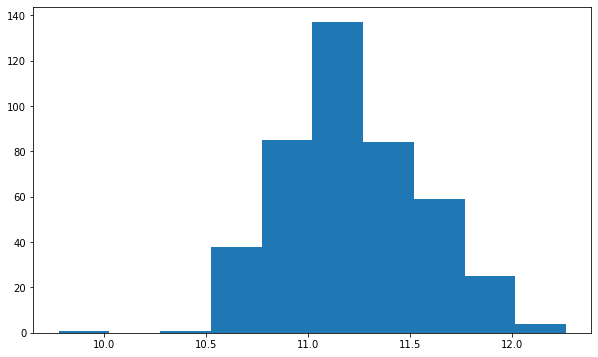

In [135]:
plt.hist(np.log10(sample_bin1_volume['cigale_mstar']));

Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [ 9.86484306 10.04248149 10.22011992 10.39775834 10.57539677 10.7530352
 10.93067362 11.10831205 11.28595048 11.4635889  11.64122733 11.81886576
 11.99650418 12.17414261]
Mbin limits:  [ 9.77602385  9.95366228 10.1313007  10.30893913 10.48657756 10.66421598
 10.84185441 11.01949284 11.19713126 11.37476969 11.55240812 11.73004654
 11.90768497 12.0853234  12.26296182]
#sources bin 0 :  0
#sources bin 1 :  0
#sources bin 2 :  0
#sources bin 3 :  1
#sources bin 4 :  13
#sources bin 5 :  43
#sources bin 6 :  67
#sources bin 7 :  104
#sources bin 8 :  70
#sources bin 9 :  51
#sources bin 10 :  52
#sources bin 11 :  21
#sources bin 12 :  9
#sources bin 13 :  2
Cosmology:  FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


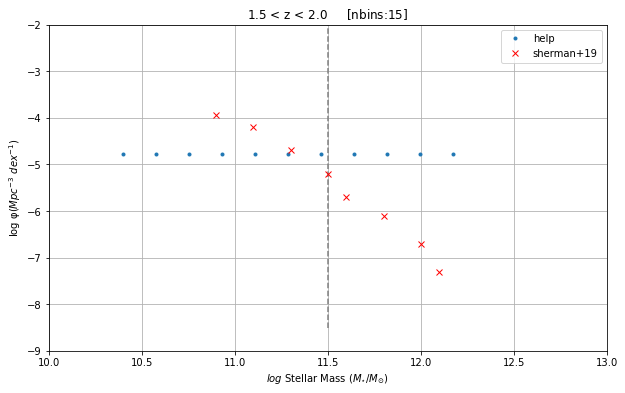

In [39]:
gsmf_b1 = plot_SMF(zmin, zmax, sample_bin1_volume, Mass, redshift,nbins=15 , vmax=True)
print('Cosmology: ', cosmo)


Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [10.31544891 10.94218471 11.08816009 11.20426859 11.3481006  11.55107333
 11.96530985]
Mbin limits:  [9.776023850305213, 10.85487397244675, 11.029495443393467, 11.146824736365875, 11.26171243723821, 11.434488769418792, 11.667657882314018, 12.262961824819438]
#sources bin 0 :  64
#sources bin 1 :  65
#sources bin 2 :  65
#sources bin 3 :  65
#sources bin 4 :  65
#sources bin 5 :  65
#sources bin 6 :  44
Cosmology:  FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


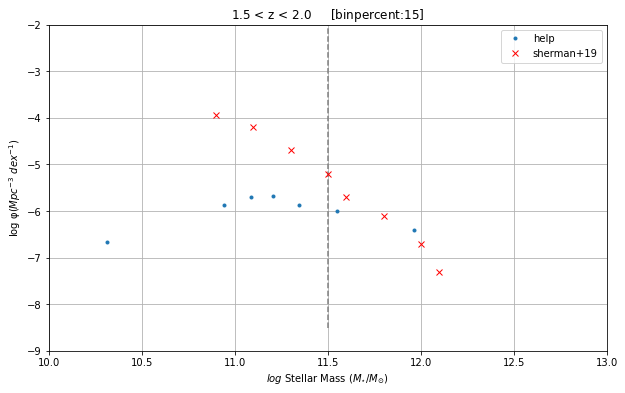

In [187]:
gsmf_b1 = plot_SMF(zmin, zmax, sample_bin1_volume, Mass, redshift, bin_percent=15, vmax=True)
print('Cosmology: ', cosmo)


Mmin:  9.776023850305213
Mmax:  12.262961824819438
Mbin centers:  [ 9.86484306 10.04248149 10.22011992 10.39775834 10.57539677 10.7530352
 10.93067362 11.10831205 11.28595048 11.4635889  11.64122733 11.81886576
 11.99650418 12.17414261]
Mbin limits:  [ 9.77602385  9.95366228 10.1313007  10.30893913 10.48657756 10.66421598
 10.84185441 11.01949284 11.19713126 11.37476969 11.55240812 11.73004654
 11.90768497 12.0853234  12.26296182]
#sources bin 0 :  0
#sources bin 1 :  0
#sources bin 2 :  0
#sources bin 3 :  1
Vmax:         Vmax       
       Mpc3       
------------------
 1891779909.588207
               nan
 2024555886.425854
 2150104721.285286
401620681.64317715
 2149972647.903098
2143592941.6159325
 2073980792.630489
2030117325.2645435
 1750244010.755471
               ...
1922425130.5603232
2130255384.1756513
1993106330.1738083
1909127102.4701297
2106986431.2843099
1975186158.9417648
2059251383.5213308
 2138040606.776016
 2147699123.634433
1892053244.7898188
Length = 434 rows
dN: 

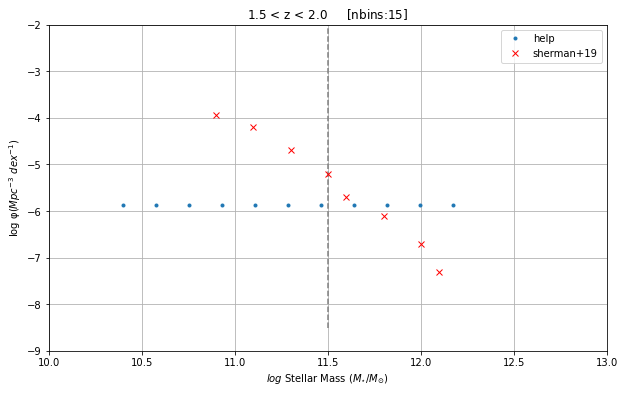

In [176]:
gsmf_b1 = plot_SMF(zmin, zmax, sample_bin1_volume, Mass, redshift, nbins=15, vmax=True)
print('Cosmology: ', cosmo)


In [71]:
np.log10(sample_bin1_volume[Mass].min())

9.776023850305213

Mmin:  9.546943119685789
Mmax:  12.479730153331582
Mbin centers:  [ 9.65168551  9.8611703  10.07065509 10.28013988 10.48962467 10.69910945
 10.90859424 11.11807903 11.32756382 11.53704861 11.74653339 11.95601818
 12.16550297 12.37498776]
Mbin limits:  [ 9.54694312  9.75642791  9.9659127  10.17539748 10.38488227 10.59436706
 10.80385185 11.01333664 11.22282142 11.43230621 11.641791   11.85127579
 12.06076058 12.27024537 12.47973015]
#sources bin 0 :  0
#sources bin 1 :  3
#sources bin 2 :  10
#sources bin 3 :  37
#sources bin 4 :  78
#sources bin 5 :  185
#sources bin 6 :  254
#sources bin 7 :  300
#sources bin 8 :  202
#sources bin 9 :  218
#sources bin 10 :  98
#sources bin 11 :  27
#sources bin 12 :  2
#sources bin 13 :  1
Cosmology:  FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


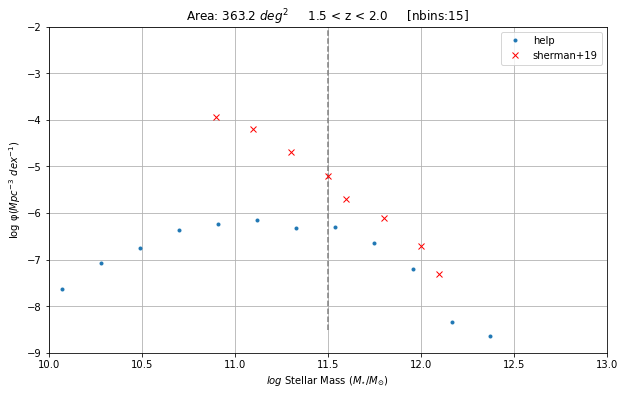

In [37]:
plot_SMF(zmin, zmax, sample_bin1_volume, Mass, redshift, nbins=15, vmax=True)
print('Cosmology: ', cosmo)


In [43]:
import h5py
import pandas as pd
from sphviewer.tools import QuickView
from matplotlib.colors import LogNorm
from virgodb import VirgoDB
import pyread_eagle as read_eagle

plt.rcParams["axes.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
# plt.rcParams["text.usetex"] = True
np.warnings.filterwarnings('ignore')


In [44]:
# Setup the connection
user = 'zpr066'
password = 'qgzII525'
url = 'http://galaxy-catalogue.dur.ac.uk:8080/Eagle/'
vdb = VirgoDB(user, password, url)

# Example - 0 
Taken from http://icc.dur.ac.uk/Eagle/database.php

RefL0100N1504
   mass   num
0   8.1  8940
1   8.3  6599
2   8.5  4985
3   8.7  3755
4   8.9  2786
AGNdT9L0050N0752
   mass   num
0   8.1  1203
1   8.3   843
2   8.5   611
3   8.7   475
4   8.9   370
RecalL0025N0752
   mass  num
0   8.1  105
1   8.3   88
2   8.5   60
3   8.7   39
4   8.9   43
Mmin:  10.095725735693737
Mmax:  12.683347929167248
Mbin centers:  [10.50121802 10.98991093 11.13176009 11.25345868 11.41494704 11.62356981
 12.2085511 ]
Mbin limits:  [10.095725735693737, 10.906710300210259, 11.073111568654571, 11.190408618281143, 11.316508745114772, 11.513385344035921, 11.733754269553229, 12.683347929167248]
#sources bin 0 :  58
#sources bin 1 :  59
#sources bin 2 :  58
#sources bin 3 :  59
#sources bin 4 :  58
#sources bin 5 :  59
#sources bin 6 :  39
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


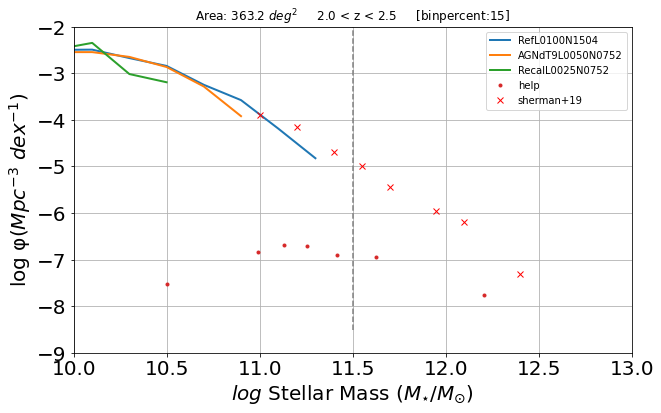

In [53]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 15
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
plot_SMF(zmin, zmax, cat, field_area, FlatLambdaCDM(H0=67.77, Om0=0.3), Mass, redshift, bin_percent=15)
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()

RefL0100N1504
   mass   num
0   8.1  7957
1   8.3  5743
2   8.5  4173
3   8.7  2995
4   8.9  2329
AGNdT9L0050N0752
   mass   num
0   8.1  1039
1   8.3   678
2   8.5   504
3   8.7   407
4   8.9   309
RecalL0025N0752
   mass  num
0   8.1   92
1   8.3   67
2   8.5   50
3   8.7   46
4   8.9   28
Mmin:  10.095725735693737
Mmax:  12.683347929167248
Mbin centers:  [10.50121802 10.98991093 11.13176009 11.25345868 11.41494704 11.62356981
 12.2085511 ]
Mbin limits:  [10.095725735693737, 10.906710300210259, 11.073111568654571, 11.190408618281143, 11.316508745114772, 11.513385344035921, 11.733754269553229, 12.683347929167248]
#sources bin 0 :  58
#sources bin 1 :  59
#sources bin 2 :  58
#sources bin 3 :  59
#sources bin 4 :  58
#sources bin 5 :  59
#sources bin 6 :  39
Cosmology:  FlatLambdaCDM(H0=67.8 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


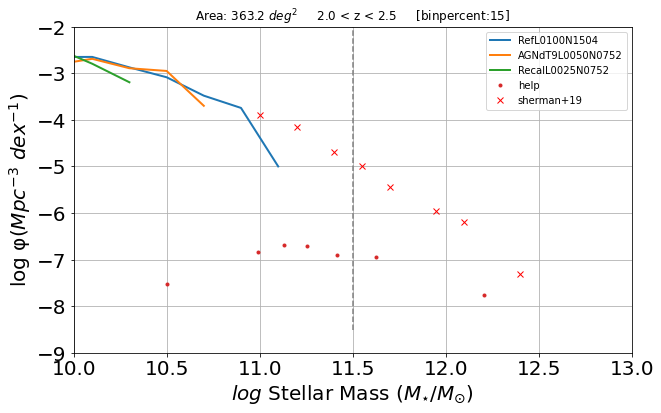

In [52]:
# Array of chosen simulations. Entries refer to the simulation name and comoving box length.
mySims= np.array([('RefL0100N1504', 100.), ('AGNdT9L0050N0752', 50.), ('RecalL0025N0752', 25.)])


for sim_name, sim_size in mySims:
    print (sim_name)
    # Construct and execute query for each simulation. This query returns the number of galaxies 
    # for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
    
    myquery = ''' SELECT        
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2 as mass,
            count(*) as num
            FROM 
            %s_SubHalo as SH,
            %s_Aperture as AP
            WHERE  
            SH.GalaxyID = AP.GalaxyID and
            AP.ApertureSize =  30 and
            AP.Mass_Star > 1e8 and       
            SH.SnapNum = 13
            GROUP BY
            0.1+floor(log10(AP.Mass_Star)/0.2)*0.2
            ORDER BY
            mass'''%(sim_name, sim_name)
            
    # Execute query.
    myData = vdb.execute_query(myquery)
    df_mydata = pd.DataFrame(myData)
    print(df_mydata[:5])

    # Normalize by volume and bin width.
    hist = myData['num'][:] / float(sim_size)**3.
    hist = hist / 0.2
    
    plt.plot(myData['mass'], np.log10(hist), label=sim_name, linewidth=2)
plot_SMF(zmin, zmax, cat, field_area, FlatLambdaCDM(H0=67.77, Om0=0.3), Mass, redshift, bin_percent=15)
print('Cosmology: ', FlatLambdaCDM(H0=67.77, Om0=0.3))

# Label plot.
#     plt.xlabel(r'log$_{10}$ M$_{*}$ [M$_{\odot}$]', fontsize=20)
#     plt.ylabel(r'log$_{10}$ dn/dlog$_{10}$(M$_{*}$) [cMpc$^{-3}$]', fontsize=20)
#     plt.tight_layout()
plt.legend()
#     plt.show()
    # plt.savefig('GSMF.png')
#     plt.close()